Import Libraries

In [1]:
import os
import json
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



Install Kaggle

In [2]:
!pip install kaggle

Load Kaggle Credentials

In [3]:
kaggle_credentails = json.load(open("kaggle.json"))

Set Kaggle API Environment Variables

In [4]:
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

Download Kaggle Dataset

In [5]:
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
100% 611M/612M [00:20<00:00, 31.5MB/s]
100% 612M/612M [00:20<00:00, 31.3MB/s]


Extract Kaggle Dataset

In [6]:
with ZipFile("gtsrb-german-traffic-sign.zip", 'r') as zip_ref:
    zip_ref.extractall()

Data Initialization

In [8]:
path = "Train"
labelFile = 'label_map.csv'
batch_size_val=32
epochs_val=10
imageDimesions = (32,32,3)
testRatio = 0.2
validationRatio = 0.2

Load and Preprocess Images

In [9]:
count = 0
images = []
classNo = []
target_shape = (32, 32)
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses=len(myList)
print("Importing Classes.....")
for x in range (0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        img = cv2.imread(path+"/"+str(count)+"/"+y)
        img_resized = cv2.resize(img, target_shape)
        images.append(img_resized)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


Split Data into Train, Test, and Validation Sets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)


Print Data Shapes

In [11]:
print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)

Data Shapes
Train(25093, 32, 32, 3) (25093,)
Validation(6274, 32, 32, 3) (6274,)
Test(7842, 32, 32, 3) (7842,)


Load and Print Label Data

In [12]:
data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


Set Up Sampling Parameters

In [13]:
num_of_samples = []
cols = 5
num_classes = noOfClasses

Define Preprocessing Functions

In [14]:
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

Apply Preprocessing to Data

In [15]:
X_train=np.array(list(map(preprocessing,X_train)))
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))

Reshape Data for Model

In [16]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

Data Augmentation and Batch Generation

In [17]:
dataGen= ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10)
dataGen.fit(X_train)
batches= dataGen.flow(X_train,y_train,batch_size=20)
X_batch,y_batch = next(batches)

Convert Labels to Categorical

In [18]:
y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)

Define Model Architecture

In [21]:
def myModel():
    model= Sequential()
    model.add((Conv2D(60,(5,5),input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(60, (5,5), activation='relu')))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add((Conv2D(30, (3,3),activation='relu')))
    model.add((Conv2D(30, (3,3), activation='relu')))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses,activation='softmax'))
    model.compile(Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model


Model Summary

In [45]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 60)          │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 60)          │          90,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 10, 10, 30)          │          16,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 8, 8, 30)            │           8,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 43)                  │          21,543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,134,071 (4.33 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 756,048 (2.88 MB)

Train Model with Early Stopping and Learning Rate Scheduler

In [33]:
model = myModel()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

history = model.fit(dataGen.flow(X_train, y_train, batch_size=batch_size_val),
                    steps_per_epoch=len(X_train) // batch_size_val,
                    epochs=epochs_val,
                    validation_data=(X_validation, y_validation),
                    callbacks=[early_stopping, reduce_lr],
                    shuffle=True)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 311s 393ms/step - accuracy: 0.1984 - loss: 2.9451 - val_accuracy: 0.8285 - val_loss: 0.6916 - learning_rate: 0.0010
Epoch 2/10
  1/784 ━━━━━━━━━━━━━━━━━━━━ 3:42 285ms/step - accuracy: 0.5312 - loss: 1.2749

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


784/784 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.5312 - loss: 1.2749 - val_accuracy: 0.8205 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 3/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 307s 391ms/step - accuracy: 0.6487 - loss: 1.1297 - val_accuracy: 0.9133 - val_loss: 0.2996 - learning_rate: 0.0010
Epoch 4/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.8125 - loss: 0.5623 - val_accuracy: 0.9297 - val_loss: 0.2408 - learning_rate: 0.0010
Epoch 5/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 336s 386ms/step - accuracy: 0.7710 - loss: 0.7505 - val_accuracy: 0.9654 - val_loss: 0.1316 - learning_rate: 0.0010
Epoch 6/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.9688 - loss: 0.1834 - val_accuracy: 0.9641 - val_loss: 0.1316 - learning_rate: 0.0010
Epoch 7/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 308s 392ms/step - accuracy: 0.8188 - loss: 0.5773 - val_accuracy: 0.9750 - val_loss: 0.1134 - learning_rate: 0.0010
Epoch 8/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.8750 - loss: 

Plot Training History and Evaluate Model

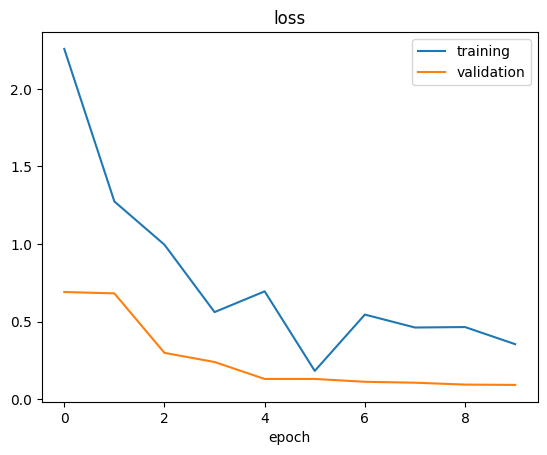

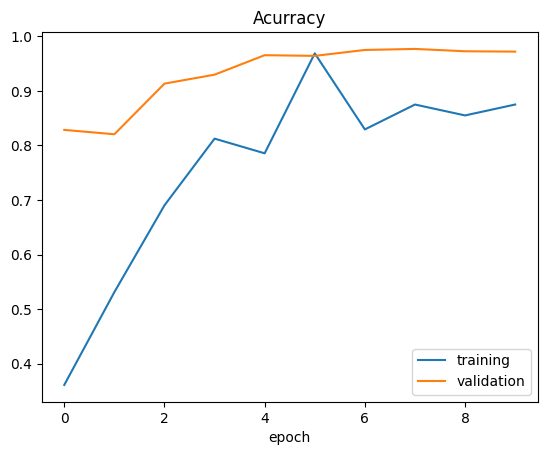

Test Score: 0.09069306403398514
Test Accuracy: 0.9753889441490173


In [34]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

Save Model

In [46]:
model.save("model.h5")

Predict and Extract Classes from Test Data

In [ ]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Classification Report

In [ ]:
class_report = classification_report(Y_true, Y_pred_classes, target_names=[label_map[i] for i in range(noOfClasses)])
print("Classification Report:\n", class_report)

Visualize Confusion Matrix

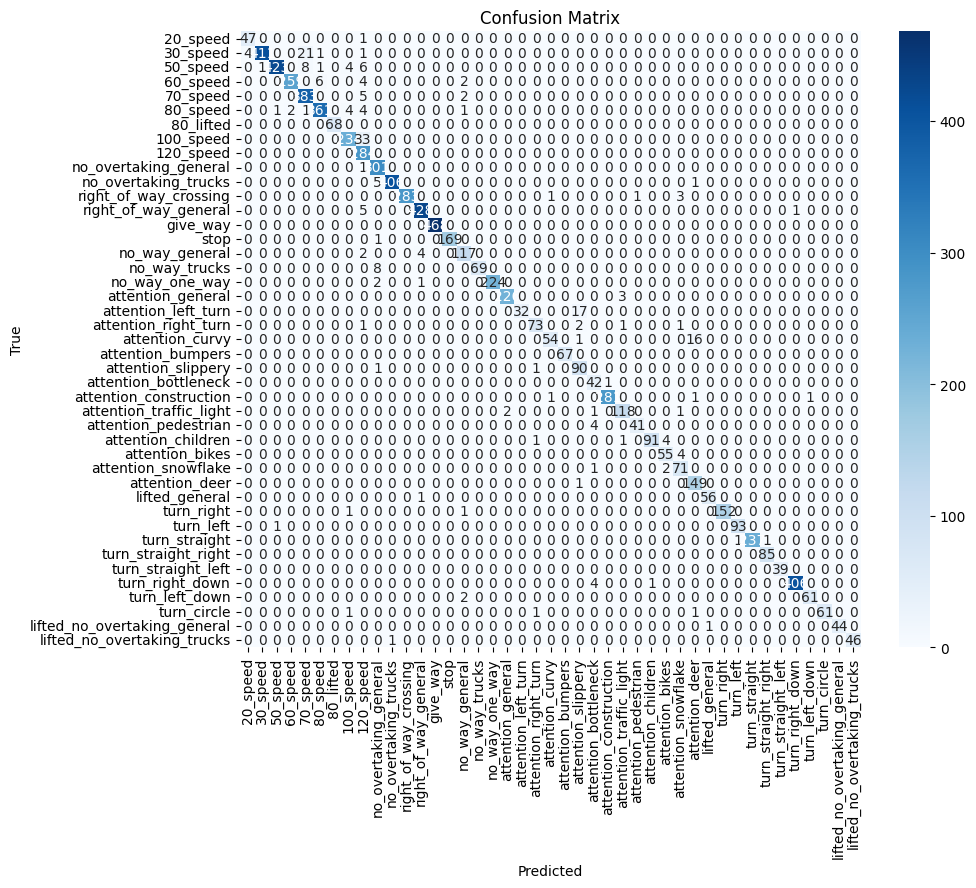

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
